<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/RNN_notebooks%20/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting the future is something you do all the time, whether you are finishing a friend’s sentence or anticipating the smell of coffee at breakfast. 

RNNs can analyze time series data, such as the number of daily active users on your website, the hourly temperature in your city, your home’s daily power consumption, the trajectories of nearby cars, and more. Once an RNN learns past patterns in the data, it is able to use its knowledge to forecast the future, assuming of course that past patterns still hold in the future.

RNNs can work on sequences of arbitrary lengths, rather than on fixed-sized inputs. For example, they can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing applications such as automatic translation or speech-to-text.

we will first go through the fundamental concepts underlying RNNs and how to train them using backpropagation through time. Then, we will use them to forecast a time series. Along the way, we will look at the popular ARMA family of models, often used to forecast time series, and use them as baselines to compare with our RNNs. After that, we’ll explore the two main difficulties that RNNs face:

Unstable gradients (discussed in Chapter 11), which can be alleviated using various techniques, including recurrent dropout and recurrent layer normalization.

A (very) limited short-term memory, which can be extended using LSTM and GRU cells.

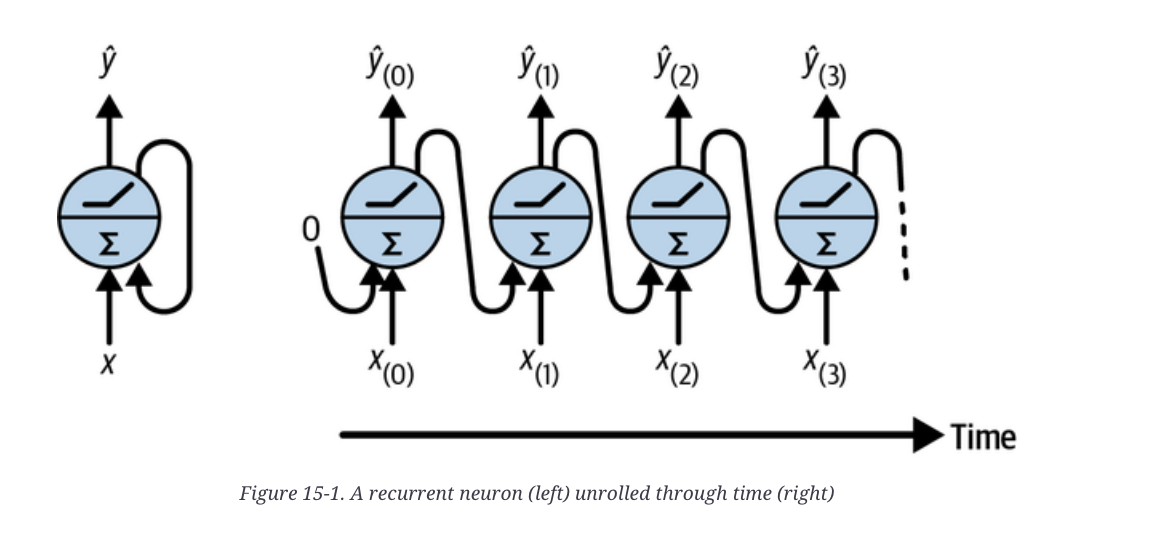

# Memory Cells
Since the output of a recurrent neuron at time step t is a function of all the inputs from previous time steps, you could say it has a form of memory. 

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (see the top-left network in Figure 15-4). This type of sequence-to-sequence network is useful to forecast time series, such as your home’s daily power consumption: you feed it the data over the last N days, and you train it to output the power consumption shifted by one day into the future (i.e., from N – 1 days ago to tomorrow).

Lastly, you could have a sequence-to-vector network, called an encoder, followed by a vector-to-sequence network, called a decoder (see the bottom-right network of Figure 15-4). For example, this could be used for translating a sentence from one language to another. You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language. This two-step model, called an **encoder–decoder**




# Training RNNs

In [20]:
import random
import os, sys
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
# Fixing the random seed
fix_random_seed(4321)
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.12.0


# Installation

In [21]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.8 MB/s eta 0:00:00


In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Forecasting a Time Series
All right! Let’s pretend you’ve just been hired as a data scientist by Chicago’s Transit Authority. Your first task is to build a model capable of forecasting the number of passengers that will ride on bus and rail the next day. You have access to daily ridership data since 2001.

In [4]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [12]:
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] 
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


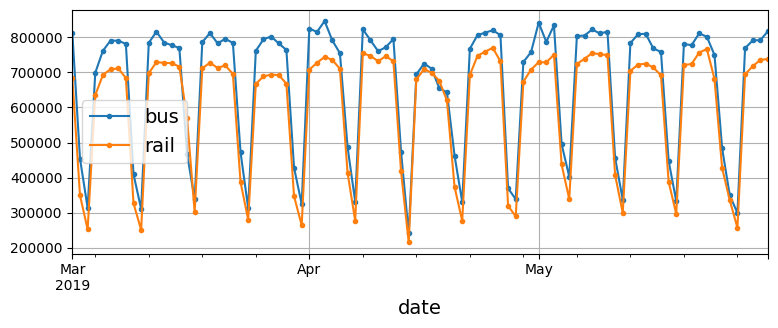

In [13]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

To visualize these naive forecasts, let’s overlay the two time series (for bus and rail) as well as the same time series lagged by one week (i.e., shifted toward the right) using dotted lines. We’ll also plot the difference between the two (i.e., the value at time t minus the value at time t – 7); this is called differencing 

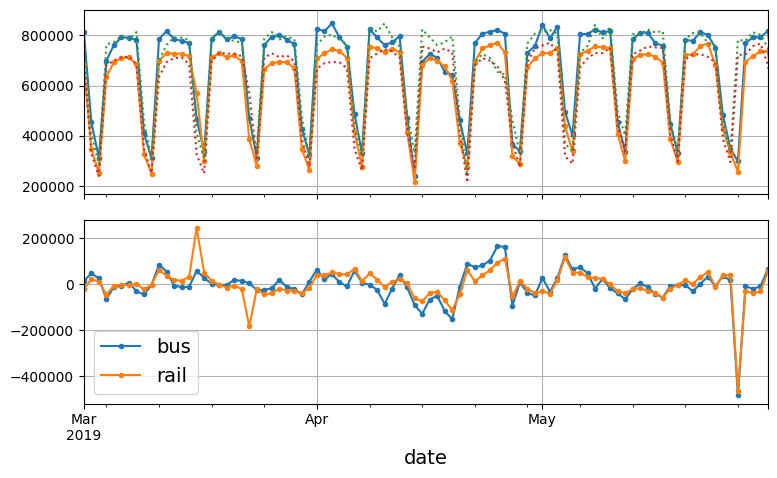

In [14]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [15]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [16]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [17]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

What we just computed is called the mean absolute percentage error (MAPE): it looks like our naive forecasts give us a MAPE of roughly 8.3% for bus and 9.0% for rail. It’s interesting to note that the MAE for the rail forecasts looks slightly better than the MAE for the bus forecasts, while the opposite is true for the MAPE. That’s because the bus ridership is larger than the rail ridership, so naturally the forecast errors are also larger, but when we put the errors into perspective, it turns out that the bus forecasts are actually slightly better than the rail forecasts.



Looking at the time series, there doesn’t appear to be any significant monthly seasonality, but let’s check whether there’s any yearly seasonality. We’ll look at the data from 2001 to 2019. To reduce the risk of data snooping, we’ll ignore more recent data for now. Let’s also plot a 12-month rolling average for each series to visualize long-term trends 

<ipython-input-18-ef5a32f2f69d>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').mean()  # compute the mean for each month


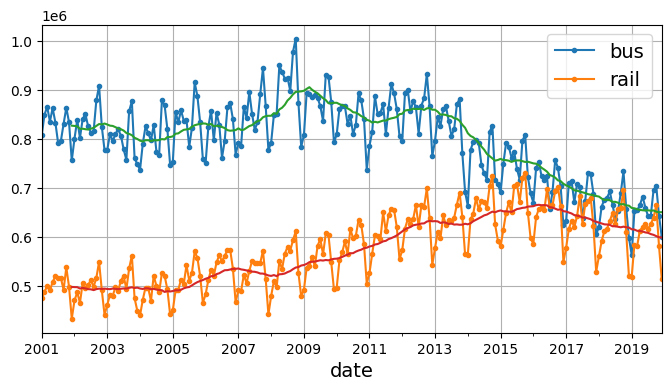

In [18]:
period = slice("2001", "2019")

df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

Yep! There’s definitely some yearly seasonality as well, although it is noisier than the weekly seasonality, and more visible for the rail series than the bus series: we see peaks and troughs at roughly the same dates each year. Let’s check what we get if we plot the 12-month difference

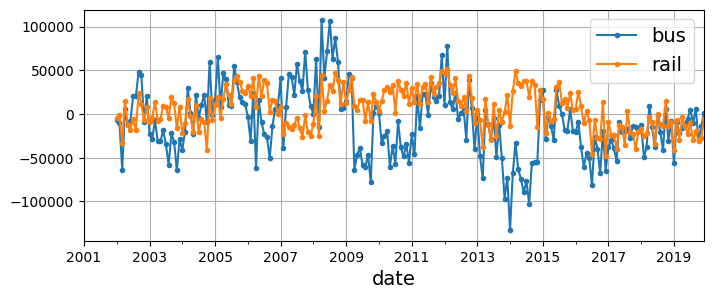

In [19]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

Notice how differencing not only removed the yearly seasonality, but it also removed the long-term trends. For example, the linear downward trend present in the time series from 2016 to 2019 became a roughly constant negative value in the differenced time series. In fact, differencing is a common technique used to remove trend and seasonality from a time series: it’s easier to study a stationary time series, meaning one whose statistical properties remain constant over time, without any seasonality or trends. Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.

# The ARMA Model Family
We’ll start with the autoregressive moving average (ARMA) model, developed by Herman Wold in the 1930s: it computes its forecasts using a simple weighted sum of lagged values and corrects these forecasts by adding a moving average, very much like we just discussed. 

Importantly, this model assumes that the time series is stationary. If it is not, then differencing may help. Using differencing over a single time step will produce an approximation of the derivative of the time series: indeed, it will give the slope of the series at each time step. This means that it will eliminate any linear trend, transforming it into a constant value.


Differencing is the central contribution of the autoregressive integrated moving average (ARIMA) model, introduced in 1970 by George Box and Gwilym Jenkins in their book Time Series Analysis (Wiley): this model runs d rounds of differencing to make the time series more stationary, then it applies a regular ARMA model. When making forecasts, it uses this ARMA model, then it adds back the terms that were subtracted by differencing.

One last member of the ARMA family is the seasonal ARIMA (SARIMA) model: it models the time series in the same way as ARIMA, but it additionally models a seasonal component for a given frequency (e.g., weekly), using the exact same ARIMA approach.

In [23]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [24]:
y_pred[0]  

427758.62641035335

In [25]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [26]:
df["rail"].loc["2019-05-25"]

426932

The forecast is 427,759 passengers, when in fact there were 379,044. Yikes, we’re 12.9% off—that’s pretty bad. It’s actually slightly worse than naive forecasting, which forecasts 426,932, off by 12.6%. But perhaps we were just unlucky that day? To check this, we can run the same code in a loop to make forecasts for every day in March, April, and May, and compute the MAE over that period:



In [27]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [28]:
mae

32040.720089453378

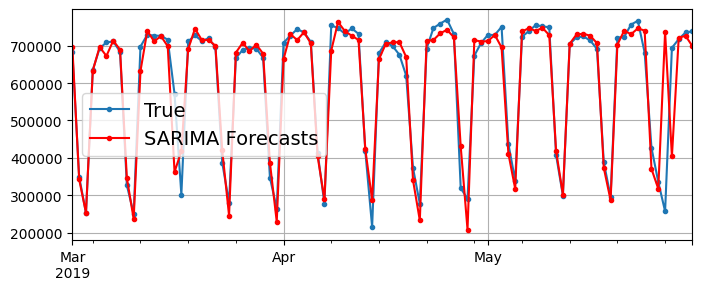

In [29]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

# Preparing the Data for Machine Learning Models

Now, before we start training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of one million, to ensure the values are near the 0–1 range; this plays nicely with the default weight initialization and learning rate:

In [30]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

When dealing with time series, you generally want to split across time. However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on. For example, if you have data about the financial health of 10,000 companies from 2001 to 2019, you might be able to split this data across the different companies. It’s very likely that many of these companies will be strongly correlated, though (e.g., whole economic sectors may go up or down jointly), and if you have correlated companies across the training set and the test set, your test set will not be as useful, as its measure of the generalization error will be optimistically biased.

Next, let’s use timeseries_dataset_from_array() to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID)

In [31]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [32]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 13ms/step - loss: 0.1234 - mae: 0.3800 - val_loss: 0.0174 - val_mae: 0.1471
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0096 - mae: 0.1034 - val_loss: 0.0065 - val_mae: 0.0849
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0066 - mae: 0.0838 - val_loss: 0.0057 - val_mae: 0.0781
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0063 - mae: 0.0819 - val_loss: 0.0051 - val_mae: 0.0728
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0055 - mae: 0.0746 - val_loss: 0.0048 - val_mae: 0.0699
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0052 - mae: 0.0726 - val_loss: 0.0073 - val_mae: 0.0929
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0066 - mae: 0.0876 - val_loss: 0.0046 - val_mae: 0.0684
Epoch 8/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0050

In [33]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 9ms/step - loss: 0.0022 - mae: 0.0371


37111.17058992386

# Forecasting Using a Simple RNN

In [37]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1])
])

All recurrent layers in Keras expect 3D inputs of shape [batch size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series. Recall that the input_shape argument ignores the first dimension (i.e., the batch size), and since recurrent layers can accept input sequences of any length, we can set the second dimension to None, which means “any size”. Lastly, since we’re dealing with a univariate time series, we need the last dimension’s size to be 1. This is why we specified the input shape [None, 1]: it means “univariate sequences of any length”. Note that the datasets actually contain inputs of shape [batch size, time steps], so we’re missing the last dimension, of size 1, but Keras is kind enough to add it for us in this case.

In [38]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [39]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 22ms/step - loss: 0.1910 - mae: 0.5472 - val_loss: 0.1077 - val_mae: 0.3847
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0691 - mae: 0.2992 - val_loss: 0.0342 - val_mae: 0.2127
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0269 - mae: 0.1919 - val_loss: 0.0230 - val_mae: 0.1729
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0206 - mae: 0.1698 - val_loss: 0.0195 - val_mae: 0.1547
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0183 - mae: 0.1619 - val_loss: 0.0175 - val_mae: 0.1457
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0171 - mae: 0.1593 - val_loss: 0.0168 - val_mae: 0.1430
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0165 - mae: 0.1568 - val_loss: 0.0160 - val_mae: 0.1422
Epoch 8/500
33/33 [==============================] - 1s 17ms/step - loss: 0.

54447.09211587906

In [53]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [54]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 4s 37ms/step - loss: 0.0130 - mae: 0.1234 - val_loss: 0.0072 - val_mae: 0.0989
Epoch 2/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0052 - mae: 0.0705 - val_loss: 0.0023 - val_mae: 0.0413
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0046 - mae: 0.0681 - val_loss: 0.0049 - val_mae: 0.0741
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0047 - mae: 0.0700 - val_loss: 0.0020 - val_mae: 0.0396
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0035 - mae: 0.0527 - val_loss: 0.0021 - val_mae: 0.0375
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0032 - mae: 0.0518 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0032 - mae: 0.0520 - val_loss: 0.0020 - val_mae: 0.0344
Epoch 8/500
33/33 [==============================] - 1s 19ms/step - loss: 0.

29943.987727165222

# Forecasting Using a Deep RNN
It is quite common to stack multiple layers of cells,  This gives you a deep RNN.

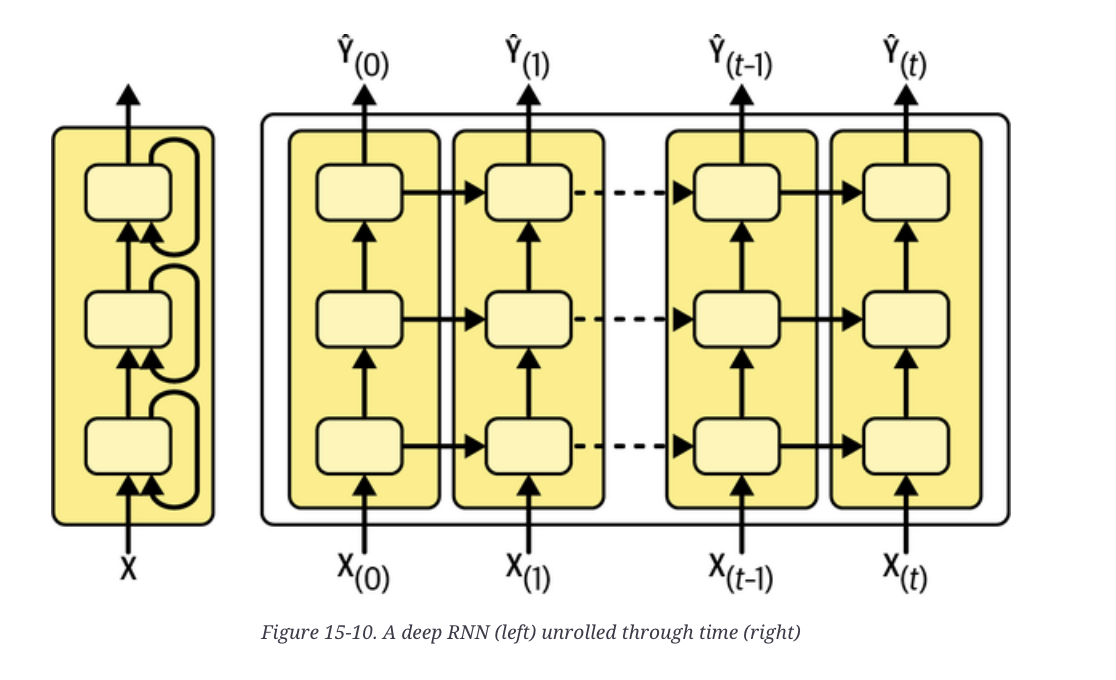

In [40]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [41]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 6s 92ms/step - loss: 0.0237 - mae: 0.1594 - val_loss: 0.0095 - val_mae: 0.1091
Epoch 2/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0087 - mae: 0.1055 - val_loss: 0.0044 - val_mae: 0.0763
Epoch 3/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0060 - mae: 0.0818 - val_loss: 0.0039 - val_mae: 0.0711
Epoch 4/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0051 - mae: 0.0728 - val_loss: 0.0024 - val_mae: 0.0496
Epoch 5/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0041 - mae: 0.0614 - val_loss: 0.0038 - val_mae: 0.0670
Epoch 6/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0040 - mae: 0.0597 - val_loss: 0.0025 - val_mae: 0.0488
Epoch 7/500
33/33 [==============================] - 2s 66ms/step - loss: 0.0039 - mae: 0.0594 - val_loss: 0.0027 - val_mae: 0.0521
Epoch 8/500
33/33 [==============================] - 2s 64ms/step - loss: 0.

28733.687475323677

Make sure to set return_sequences=True for all recurrent layers (except the last one, if you only care about the last output). If you forget to set this parameter for one recurrent layer, it will output a 2D array containing only the output of the last time step, instead of a 3D array containing outputs for all time steps. The next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

# Forecasting Multivariate Time Series
A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input. In fact, let’s also throw in the day type! Since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input.

In [42]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [43]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [44]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [45]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [46]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 25ms/step - loss: 0.0395 - mae: 0.1951 - val_loss: 0.0021 - val_mae: 0.0524
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0034 - mae: 0.0647 - val_loss: 0.0013 - val_mae: 0.0386
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0021 - mae: 0.0451 - val_loss: 8.1711e-04 - val_mae: 0.0294
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0020 - mae: 0.0438 - val_loss: 0.0015 - val_mae: 0.0443
Epoch 5/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0017 - mae: 0.0400 - val_loss: 8.3179e-04 - val_mae: 0.0295
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0018 - mae: 0.0429 - val_loss: 9.6490e-04 - val_mae: 0.0325
Epoch 7/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0016 - mae: 0.0411 - val_loss: 7.9467e-04 - val_mae: 0.0284
Epoch 8/500
33/33 [==============================] - 1s 17ms

23268.092423677444

In [47]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 3s 26ms/step - loss: 0.0315 - mae: 0.1880 - val_loss: 0.0051 - val_mae: 0.0853
Epoch 2/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0038 - mae: 0.0622 - val_loss: 0.0015 - val_mae: 0.0385
Epoch 3/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0025 - mae: 0.0487 - val_loss: 0.0012 - val_mae: 0.0339
Epoch 4/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0022 - mae: 0.0466 - val_loss: 0.0019 - val_mae: 0.0509
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0020 - mae: 0.0451 - val_loss: 0.0011 - val_mae: 0.0349
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0019 - mae: 0.0430 - val_loss: 0.0011 - val_mae: 0.0351
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0018 - mae: 0.0421 - val_loss: 9.9745e-04 - val_mae: 0.0333
Epoch 8/500
33/33 [==============================] - 1s 18ms/step - loss

25736.398994922638

In [48]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 1s 10ms/step
bus 26246
rail 25225


# Forecasting Several Time Steps Ahead
So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead). But what if we want to predict the next 14 values?

In [55]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 28ms/step


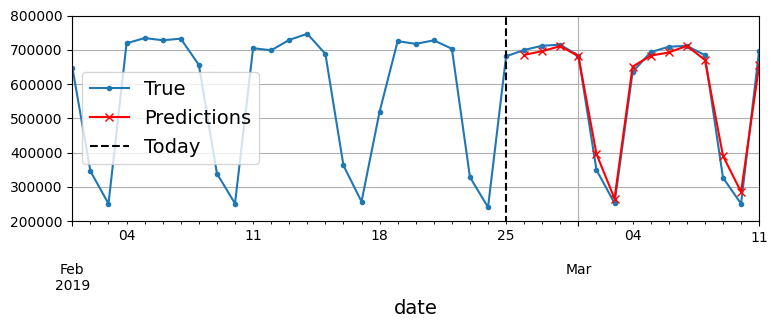

In [56]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

In [57]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [58]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])


In [59]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 3s 42ms/step - loss: 0.0861 - mae: 0.3147 - val_loss: 0.0228 - val_mae: 0.1628
Epoch 2/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0178 - mae: 0.1507 - val_loss: 0.0139 - val_mae: 0.1261
Epoch 3/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0134 - mae: 0.1320 - val_loss: 0.0117 - val_mae: 0.1166
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0120 - mae: 0.1243 - val_loss: 0.0106 - val_mae: 0.1113
Epoch 5/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0110 - mae: 0.1196 - val_loss: 0.0099 - val_mae: 0.1056
Epoch 6/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0102 - mae: 0.1134 - val_loss: 0.0089 - val_mae: 0.1024
Epoch 7/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0096 - mae: 0.1090 - val_loss: 0.0081 - val_mae: 0.0977
Epoch 8/500
33/33 [==============================] - 1s 27ms/step - loss: 0.

35071.782767772675

In [60]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)

1/1 [==============================] - 0s 166ms/step


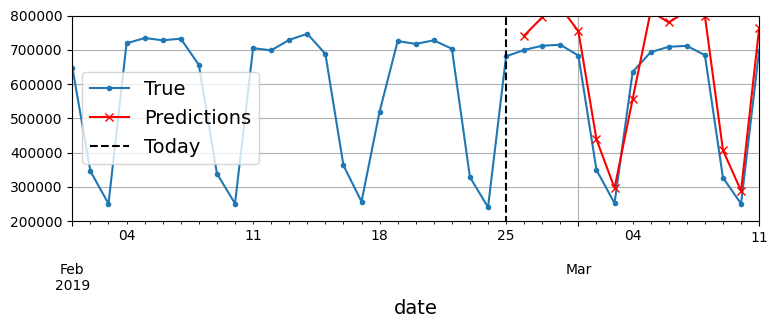

In [61]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

# Forecasting Using a Sequence-to-Sequence Model

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just for the output at the last time step.

This means there will be many more error gradients flowing through the model, and they won’t have to flow through time as much since they will come from the output of each time step, not just the last one. This will both stabilize and speed up training.

To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 14, then at time step 1 the model will forecast time steps 2 to 15, and so on. In other words, the targets are sequences of consecutive windows, shifted by one time step at each time step. The target is not a vector anymore, but a sequence of the same length as the inputs, containing a 14-dimensional vector at each step.

Preparing the datasets is not trivial, since each instance has a window as input and a sequence of windows as output. One way to do this is to use the to_windows() utility function we created earlier, twice in a row, to get windows of consecutive windows. For example, let’s turn the series of numbers 0 to 6 into a dataset containing sequences of 4 consecutive windows, each of length 3:

In [63]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [64]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Let’s create another little utility function to prepare the datasets for our sequence-to-sequence model. It will also take care of shuffling (optional) and batching:



In [65]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [66]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [67]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [68]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 6s 80ms/step - loss: 0.0546 - mae: 0.2413 - val_loss: 0.0163 - val_mae: 0.1346
Epoch 2/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0118 - mae: 0.1168 - val_loss: 0.0096 - val_mae: 0.1010
Epoch 3/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0086 - mae: 0.0956 - val_loss: 0.0078 - val_mae: 0.0870
Epoch 4/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0070 - mae: 0.0843 - val_loss: 0.0065 - val_mae: 0.0783
Epoch 5/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0060 - mae: 0.0761 - val_loss: 0.0055 - val_mae: 0.0701
Epoch 6/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0053 - mae: 0.0705 - val_loss: 0.0054 - val_mae: 0.0705
Epoch 7/500
33/33 [==============================] - 1s 23ms/step - loss: 0.0049 - mae: 0.0666 - val_loss: 0.0049 - val_mae: 0.0650
Epoch 8/500
33/33 [==============================] - 1s 31ms/step - loss: 0.

46709.25438404083

In [69]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 280ms/step


In [70]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 24ms/step
MAE for +1: 24,004
MAE for +2: 29,591
MAE for +3: 30,113
MAE for +4: 31,695
MAE for +5: 33,259
MAE for +6: 34,598
MAE for +7: 34,543
MAE for +8: 37,022
MAE for +9: 34,347
MAE for +10: 32,945
MAE for +11: 37,186
MAE for +12: 36,875
MAE for +13: 36,073
MAE for +14: 34,978


# Handling Long Sequences
To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, discussed in Chapter 11: it may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence. Let’s look at both these problems, starting with the unstable gradients problem.

Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here. In fact, they may actually lead the RNN to be even more unstable during training. Why? Well, suppose gradient descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that.

Note: You can reduce this risk by using a smaller learning rate, or you can use a saturating activation function like the hyperbolic tangent (this explains why it’s the default).

In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use gradient clipping.

Moreover, batch normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.



You can reduce this risk by using a smaller learning rate, or you can use a saturating activation function like the hyperbolic tangent (this explains why it’s the default).

In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use gradient clipping.

Moreover, batch normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.

To be more precise, it is technically possible to add a BN layer to a memory cell (as you will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results, as was demonstrated by César Laurent et al. in a 2015 paper:⁠7 the authors found that BN was slightly beneficial only when it was applied to the layer’s inputs, not to the hidden states. In other words, it was slightly better than nothing when applied between recurrent layers (i.e., vertically in Figure 15-10), but not within recurrent layers (i.e., horizontally). In Keras, you can apply BN between layers simply by adding a BatchNormalization layer before each recurrent layer, but it will slow down training, and it may not help much.





Let’s use Keras to implement layer normalization within a simple memory cell. To do this, we need to define a custom memory cell, which is just like a regular layer, except its call() method takes two arguments: the inputs at the current time step and the hidden states from the previous time step.

Note that the states argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short-term state, as you will see shortly). A cell must also have a state_size attribute and an output_size attribute. In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell that will behave like a SimpleRNNCell, except it will also apply layer normalization at each time step:

In [71]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Let’s walk through this code:

Our LNSimpleRNNCell class inherits from the tf.keras.layers.Layer class, just like any custom layer.

The constructor takes the number of units and the desired activation function and sets the state_size and output_size attributes, then creates a SimpleRNNCell with no activation function (because we want to perform layer normalization after the linear operation but before the activation function).⁠9 Then the constructor creates the LayerNormalization layer, and finally it fetches the desired activation function.

The call() method starts by applying the simpleRNNCell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a SimpleRNNCell, the outputs are just equal to the hidden states: in other words, new_states[0] is equal to outputs, so we can safely ignore new_states in the rest of the call() method). Next, the call() method applies layer normalization, followed by the activation function. Finally, it returns the outputs twice: once as the outputs, and once as the new hidden states. To use this custom cell, all we need to do is create a tf.keras.layers.RNN layer, passing it a cell instance:

In [72]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [73]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)


Epoch 1/5
33/33 [==============================] - 4s 49ms/step - loss: 0.0691 - mae: 0.2630 - val_loss: 0.0198 - val_mae: 0.1405
Epoch 2/5
33/33 [==============================] - 2s 66ms/step - loss: 0.0132 - mae: 0.1339 - val_loss: 0.0133 - val_mae: 0.1189
Epoch 3/5
33/33 [==============================] - 2s 56ms/step - loss: 0.0110 - mae: 0.1185 - val_loss: 0.0116 - val_mae: 0.1086
Epoch 4/5
33/33 [==============================] - 1s 37ms/step - loss: 0.0097 - mae: 0.1076 - val_loss: 0.0110 - val_mae: 0.1045
Epoch 5/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0093 - mae: 0.0948


94781.15290403366

Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: most recurrent layers and cells provided by Keras have dropout and recurrent_dropout hyperparameters: the former defines the dropout rate to apply to the inputs, and the latter defines the dropout rate for the hidden states, between time steps. So, there’s no need to create a custom cell to apply dropout at each time step in an RNN.

With these techniques, you can alleviate the unstable gradients problem and train an RNN much more efficiently. Now let’s look at how to deal with the short-term memory problem.

In [74]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [75]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [76]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 7s 116ms/step - loss: 0.0706 - mae: 0.2660 - val_loss: 0.0182 - val_mae: 0.1576
Epoch 2/5
33/33 [==============================] - 2s 46ms/step - loss: 0.0155 - mae: 0.1489 - val_loss: 0.0161 - val_mae: 0.1330
Epoch 3/5
33/33 [==============================] - 1s 39ms/step - loss: 0.0132 - mae: 0.1367 - val_loss: 0.0150 - val_mae: 0.1253
Epoch 4/5
33/33 [==============================] - 1s 38ms/step - loss: 0.0120 - mae: 0.1279 - val_loss: 0.0133 - val_mae: 0.1200
Epoch 5/5
3/3 [==============================] - 0s 31ms/step - loss: 0.0127 - mae: 0.1151


115072.8315114975

# Tackling the Short-Term Memory Problem
Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper. Imagine Dory the fish⁠10 trying to translate a long sentence; by the time she’s finished reading it, she has no clue how it started. To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not used much anymore. Let’s first look at the most popular of these long-term memory cells: the LSTM cell.

you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect longer-term patterns in the data.

In [77]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [78]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 11s 54ms/step - loss: 0.0655 - mae: 0.2752 - val_loss: 0.0184 - val_mae: 0.1582
Epoch 2/5
33/33 [==============================] - 1s 35ms/step - loss: 0.0171 - mae: 0.1605 - val_loss: 0.0178 - val_mae: 0.1445
Epoch 3/5
33/33 [==============================] - 1s 35ms/step - loss: 0.0158 - mae: 0.1532 - val_loss: 0.0169 - val_mae: 0.1428
Epoch 4/5
33/33 [==============================] - 2s 62ms/step - loss: 0.0152 - mae: 0.1498 - val_loss: 0.0163 - val_mae: 0.1401
Epoch 5/5
3/3 [==============================] - 0s 33ms/step - loss: 0.0158 - mae: 0.1372


137224.27189350128

# GRU cells
The gated recurrent unit (GRU) cell (see Figure 15-13) was proposed by Kyunghyun Cho et al. in a 2014 paper⁠14 that also introduced the encoder–decoder network we discussed earlier.

# Using 1D convolutional layers to process sequences

we saw that a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). If you use 10 kernels, then the layer’s output will be composed of 10 1D sequences (all of the same length), or equivalently you can view this output as a single 10D sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers). If you use a 1D convolutional layer with a stride of 1 and "same" padding, then the output sequence will have the same length as the input sequence. But if you use "valid" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly.





For example, the following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. By shortening the sequences the convolutional layer may help the GRU layers detect longer patterns, so we can afford to double the input sequence length to 112 days. Note that we must also crop off the first three time steps in the targets: indeed, the kernel’s size is 4, so the first output of the convolutional layer will be based on the input time steps 0 to 3, and the first forecasts will be for time steps 4 to 17 (instead of time steps 1 to 14). Moreover, we must downsample the targets by a factor of 2, because of the stride:

In [79]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))



In [81]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=500)

Epoch 1/500
31/31 [==============================] - 6s 59ms/step - loss: 0.0102 - mae: 0.1166 - val_loss: 0.0113 - val_mae: 0.1104
Epoch 2/500
31/31 [==============================] - 1s 43ms/step - loss: 0.0092 - mae: 0.1084 - val_loss: 0.0102 - val_mae: 0.1047
Epoch 3/500
31/31 [==============================] - 1s 43ms/step - loss: 0.0084 - mae: 0.1015 - val_loss: 0.0094 - val_mae: 0.1001
Epoch 4/500
31/31 [==============================] - 2s 45ms/step - loss: 0.0078 - mae: 0.0964 - val_loss: 0.0089 - val_mae: 0.0971
Epoch 5/500
31/31 [==============================] - 3s 73ms/step - loss: 0.0073 - mae: 0.0923 - val_loss: 0.0085 - val_mae: 0.0941
Epoch 6/500
31/31 [==============================] - 2s 57ms/step - loss: 0.0069 - mae: 0.0889 - val_loss: 0.0079 - val_mae: 0.0904
Epoch 7/500
31/31 [==============================] - 1s 44ms/step - loss: 0.0067 - mae: 0.0863 - val_loss: 0.0079 - val_mae: 0.0896
Epoch 8/500
31/31 [==============================] - 2s 43ms/step - loss: 0.

48819.683492183685

# WaveNet
In a 2016 paper,⁠16 Aaron van den Oord and other DeepMind researchers introduced a novel architecture called WaveNet. They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-14). This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

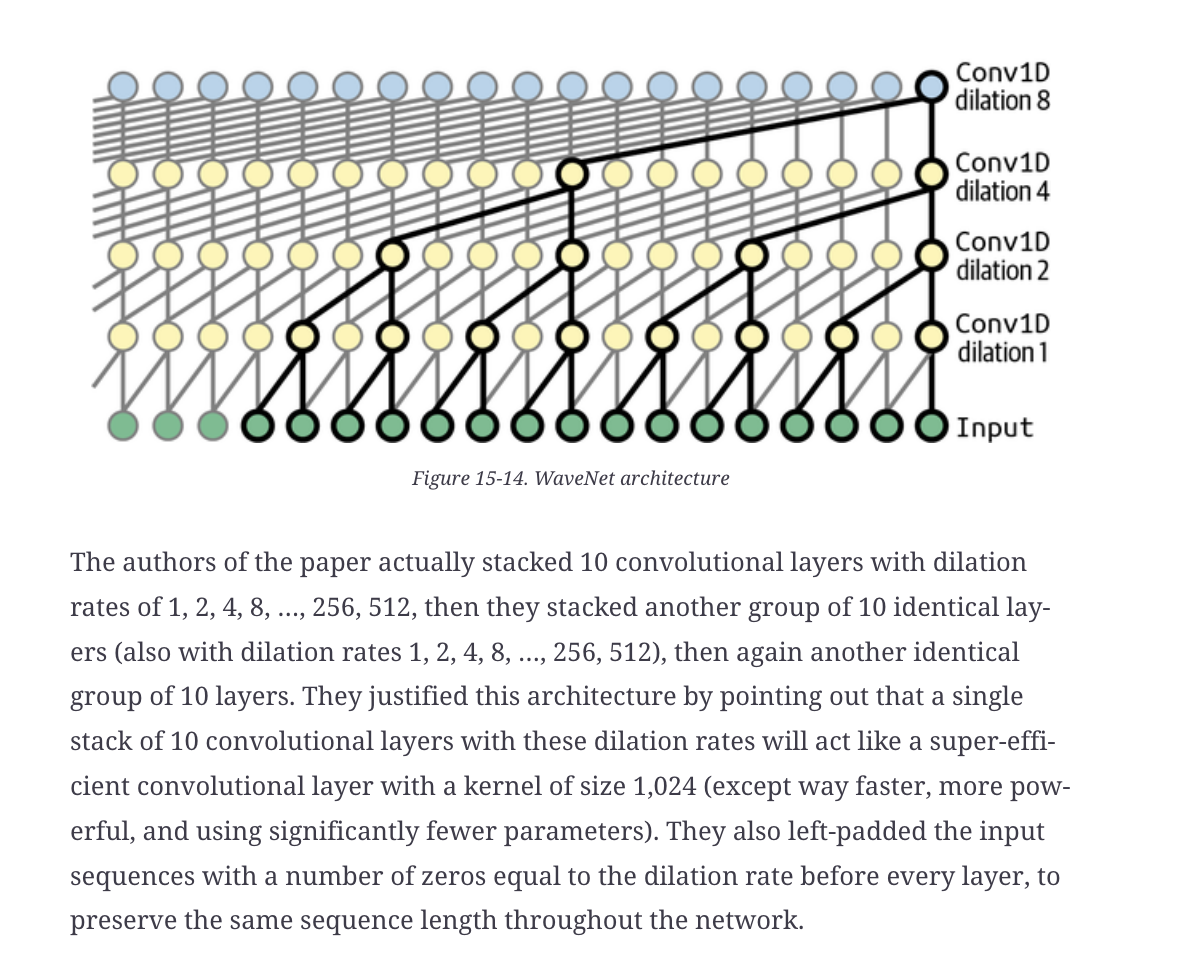

In [82]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [83]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)


Epoch 1/5
31/31 [==============================] - 5s 68ms/step - loss: 0.0816 - mae: 0.3211 - val_loss: 0.0247 - val_mae: 0.1613
Epoch 2/5
31/31 [==============================] - 2s 70ms/step - loss: 0.0171 - mae: 0.1565 - val_loss: 0.0182 - val_mae: 0.1529
Epoch 3/5
31/31 [==============================] - 2s 45ms/step - loss: 0.0156 - mae: 0.1546 - val_loss: 0.0179 - val_mae: 0.1473
Epoch 4/5
31/31 [==============================] - 1s 44ms/step - loss: 0.0149 - mae: 0.1492 - val_loss: 0.0170 - val_mae: 0.1433
Epoch 5/5
1/1 [==============================] - 0s 159ms/step - loss: 0.0158 - mae: 0.1357


135737.71715164185

# If you evaluate our best Chicago ridership models on the test period, starting in 2020, you will find that they perform much worse than expected! Why is that? Well, that’s when the Covid-19 pandemic started, which greatly affected public transportation. As mentioned earlier, these models will only work well if the patterns they learned from the past continue in the future. In any case, before deploying a model to production, verify that it works well on recent data. And once it’s in production, make sure to monitor its performance regularly.

In [84]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [85]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [86]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [87]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 4s 71ms/step - loss: 0.0544 - mae: 0.2581 - val_loss: 0.0181 - val_mae: 0.1508
Epoch 2/5
31/31 [==============================] - 2s 54ms/step - loss: 0.0138 - mae: 0.1394 - val_loss: 0.0147 - val_mae: 0.1284
Epoch 3/5
31/31 [==============================] - 2s 54ms/step - loss: 0.0111 - mae: 0.1232 - val_loss: 0.0122 - val_mae: 0.1193
Epoch 4/5
31/31 [==============================] - 2s 53ms/step - loss: 0.0095 - mae: 0.1115 - val_loss: 0.0109 - val_mae: 0.1103
Epoch 5/5
1/1 [==============================] - 0s 101ms/step - loss: 0.0093 - mae: 0.1010


100971.74346446991